# Price Prediction Models

Compare many prediction models on market price.

## Load Libraries

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device={device}')

# Set PyTorch to print tensors in non-scientific format
torch.set_printoptions(sci_mode=False)
# Disable scientific notation
np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:.6f}'.format

device=cpu


In [ ]:
import price_utils
#import price_prediction_models

from price_utils import *
#from price_prediction_models import *

## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
filepath = '/content/drive/My Drive/Crypto/data'
data = pd.read_csv(f'{filepath}/solana_historical_data.csv') # From Binance API
data.reset_index(drop=True, inplace=True)
data['datetime'] = pd.to_datetime(data['datetime'])
data.head(n=1)

,datetime,open_price,high_price,low_price,close_price,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base,taker_buy_quote,ignore
0,2020-08-11 04:00:00,2.850000,3.470000,2.850000,2.922400,62101.630000,1597132799999,186599.124921,739,23866.780000,72000.300487,0


In [ ]:
min_max_dates(data)

min_date=2020-08-11 04:00:00; max_date=2025-02-05 16:00:00
days_between=1639
years=4; months=5; days=19


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9838 entries, 0 to 9837
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   datetime            9838 non-null   datetime64[ns]
 1   open_price          9838 non-null   float64       
 2   high_price          9838 non-null   float64       
 3   low_price           9838 non-null   float64       
 4   close_price         9838 non-null   float64       
 5   volume              9838 non-null   float64       
 6   close_time          9838 non-null   int64         
 7   quote_asset_volume  9838 non-null   float64       
 8   number_of_trades    9838 non-null   int64         
 9   taker_buy_base      9838 non-null   float64       
 10  taker_buy_quote     9838 non-null   float64       
 11  ignore              9838 non-null   int64         
dtypes: datetime64[ns](1), float64(8), int64(3)
memory usage: 922.4 KB


In [ ]:
new_df = generate_training_dataset(data)
new_df.head(n=1)

,datetime,pivot_price,pre_open_price,pre_high_price,pre_low_price,pre_close_price,pre_volume,pre_quote_asset_volume,pre_number_of_trades,pre_taker_buy_base,pre_taker_buy_quote
0,2020-08-11 11:59:59.999,3.049700,2.850000,3.470000,2.850000,2.922400,62101.630000,186599.124921,739.000000,23866.780000,72000.300487


## Define models

In [ ]:
print(f"input_dim={input_dim};hidden_dim={hidden_dim};n_heads={n_heads};n_layers={n_layers}")

input_dim=9;hidden_dim=64;n_heads=4;n_layers=2


 The model trains on a sequence of 7 days' prices, retrains for a few iterations, predicts the next day's price, and moves the window forward by one day.

### TemporalTransformer

In [ ]:
# Temporal Transformer Model
class TemporalTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_heads, n_layers):
        super(TemporalTransformer, self).__init__()
        self.input_dim = input_dim

        # Linear encoding layer
        self.embedding = nn.Linear(input_dim, hidden_dim)

        # Transformer encoder layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=n_heads,
            batch_first=True)

        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Output layer
        output_dim = 1 # output just one price
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Input shape: (batch_size, seq_len, input_dim)
        x = self.embedding(x)  # (batch_size, seq_len, hidden_dim)
        if x.dim() == 2:  # If input has only 2 dimensions (batch_size, input_dim)
            x = x.unsqueeze(1)  # Add a dimension for seq_len, (batch_size, 1, input_dim)
        #print(f"[DEBUG]x.shape={x.shape}")
        x = x.permute(1, 0, 2)  # (seq_len, batch_size, hidden_dim) for transformer
        x = self.transformer(x)  # (seq_len, batch_size, hidden_dim)
        x = x[-1]  # Take the last timestep output
        x = self.fc(x)  # (batch_size, output_dim)
        x = x.squeeze(1)  # Remove the extra dimension (batch_size, 1, output_dim) -> (batch_size, output_dim)
        return x

### LSTMGRUModel

In [ ]:
class LSTMGRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, dropout=0.1):
        super(LSTMGRUModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout)
        # GRU layer
        self.gru = nn.GRU(hidden_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout)
        # Fully connected output layer
        self.fc = nn.Linear(hidden_dim, 1)  # Predicting a single value

    def forward(self, x):
        # LSTM forward pass
        lstm_out, _ = self.lstm(x)
        if lstm_out.dim() == 2:  # If input has only 2 dimensions (batch_size, input_dim)
          lstm_out = lstm_out.unsqueeze(1)  # Add a dimension for seq_len, (batch_size, 1, input_dim)
        # GRU forward pass, (batch_size, seq_len, hidden_dim)
        gru_out, _ = self.gru(lstm_out)
        # Take the last time step output
        out = gru_out[:, -1, :]
        out = self.fc(out)
        out = out.squeeze(1)  # Remove the extra dimension (batch_size, 1, output_dim) -> (batch_size, output_dim)
        return out

### ML

In [ ]:
# XGBoost (Extreme Gradient Boosting). Uses XGBoost Regressor to predict future values, which is a gradient boosting algorithm that can be used for time-series prediction by transforming sequential data into a tabular format.

## Training

In [ ]:
model = TemporalTransformer(input_dim, hidden_dim, n_heads, n_layers)
#model = LSTMGRUModel(input_dim, hidden_dim, n_layers)
model = model.to(device)
print(model)

TemporalTransformer(
  (embedding): Linear(in_features=9, out_features=64, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
values = new_df[['datetime'] + features + [independent_var]].values
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Perform rolling training and prediction
predictions = rolling_train_and_predict(values=values,
                                        seq_len=sequence_length,
                                        model=model,
                                        criterion=criterion,
                                        optimizer=optimizer,
                                        num_epochs=num_epochs)

[DEBUG]start_idx=2;end_idx=20
test_date=2020-08-14 19:59:59.999000;actual=3.3792;prediction=3.6921353340148926;loss=0.3129353340148926
[DEBUG]start_idx=12;end_idx=30
test_date=2020-08-16 11:59:59.999000;actual=3.4193;prediction=3.748469591140747;loss=0.3291695911407473
[DEBUG]start_idx=22;end_idx=40
test_date=2020-08-18 03:59:59.999000;actual=3.0328;prediction=3.4742698669433594;loss=0.44146986694335943
[DEBUG]start_idx=32;end_idx=50
test_date=2020-08-19 19:59:59.999000;actual=2.9404;prediction=3.4913933277130127;loss=0.5509933277130128
[DEBUG]start_idx=42;end_idx=60
test_date=2020-08-21 11:59:59.999000;actual=3.0918;prediction=3.4137685298919678;loss=0.32196852989196767
[DEBUG]start_idx=52;end_idx=70
test_date=2020-08-23 03:59:59.999000;actual=3.1121;prediction=3.1373419761657715;loss=0.025241976165771618
[DEBUG]start_idx=62;end_idx=80
test_date=2020-08-24 19:59:59.999000;actual=3.2812;prediction=3.1948673725128174;loss=0.08633262748718273
[DEBUG]start_idx=72;end_idx=90
test_date=2020

In [ ]:
predictions

,date,pivot_price,pred_pivot_price,loss
0,2020-08-14 11:59:59.999,3.717300,3.355155,0.362145
1,2020-08-14 15:59:59.999,3.578800,3.931366,0.352566
2,2020-08-14 19:59:59.999,3.379200,3.692135,0.312935
3,2020-08-14 23:59:59.999,3.409900,3.816487,0.406587
4,2020-08-15 03:59:59.999,3.328900,3.797362,0.468462
...,...,...,...,...
9813,2025-02-04 23:59:59.999,206.640000,210.702850,4.062850
9814,2025-02-05 03:59:59.999,207.380000,208.614975,1.234975
9815,2025-02-05 07:59:59.999,205.070000,208.336349,3.266349
9816,2025-02-05 11:59:59.999,206.330000,207.856415,1.526415


## Evaluation

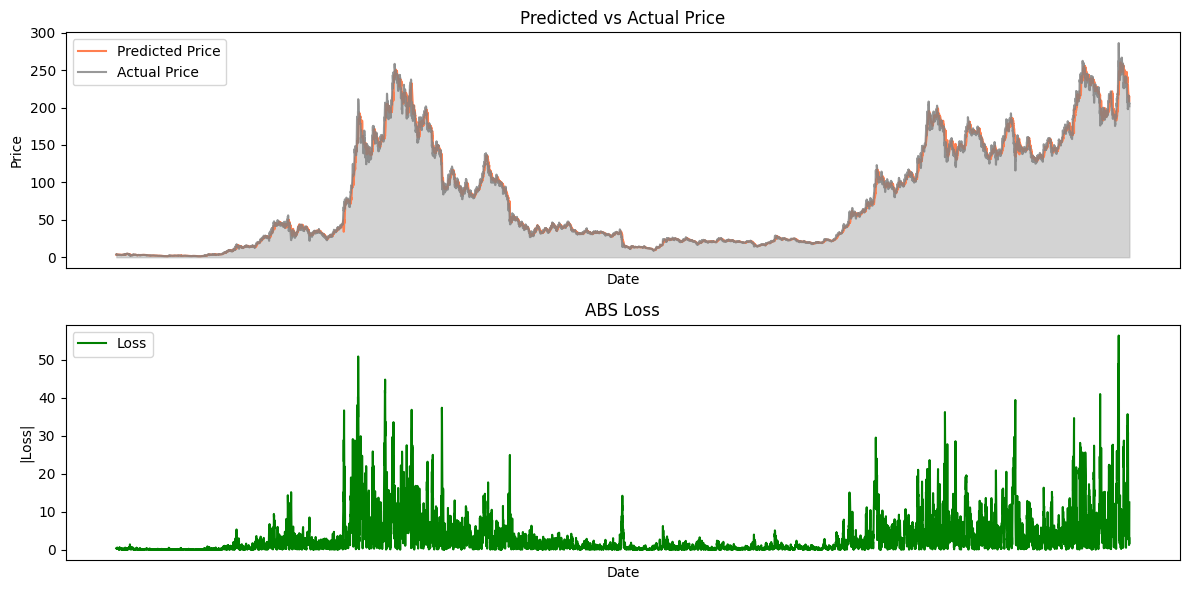

In [ ]:
import matplotlib.pyplot as plt
plot_predictions_actuals(predictions)

In [ ]:
# calculate the average loss
average_loss = predictions['loss'].mean()
print(f'average_loss={average_loss}')

# Transformer, average_loss=3.412244207422124
# LSTM, average_loss=4.581845965447798

average_loss=3.412244207422124


In [ ]:
# Print the datetime with the highest losses
highest_losses = predictions.nlargest(20, 'loss')
print(highest_losses)

                        date  pivot_price  pred_pivot_price      loss
9714 2025-01-19 11:59:59.999   286.240000        229.918228 56.321772
2344 2021-09-09 03:59:59.999   211.250000        160.432220 50.817780
9709 2025-01-18 15:59:59.999   257.750000        208.889786 48.860214
9713 2025-01-19 07:59:59.999   271.530000        223.201096 48.328904
9716 2025-01-19 19:59:59.999   269.500000        221.172943 48.327057
2605 2021-10-22 15:59:59.999   206.530000        161.791367 44.738633
9715 2025-01-19 15:59:59.999   270.580000        226.546616 44.033384
2345 2021-09-09 07:59:59.999   207.540000        164.862717 42.677283
2603 2021-10-22 07:59:59.999   203.240000        161.308182 41.931818
9711 2025-01-18 23:59:59.999   261.970000        220.798569 41.171431
2604 2021-10-22 11:59:59.999   204.180000        163.036652 41.143348
9534 2024-12-20 11:59:59.999   176.010000        216.943573 40.933573
2602 2021-10-22 03:59:59.999   201.710000        160.984573 40.725427
2342 2021-09-08 19:5

### **4️⃣ Example Interpretation**
| Metric | Value | Meaning |
|--------|-------|---------|
| **MAE** | 2.0 USDT | On average, predictions are off by **$2**. |
| **RMSE** | 2.5 USDT | Larger errors are penalized, meaning some predictions deviate more significantly. |
| **MAPE** | 1.5% | Predictions are **1.5% off** on average. |
| **R²** | 0.92 | Model explains **92%** of price variance (very good). |
| **DA** | 80% | Model correctly predicts **80%** of price movements. |

If your model has **low MAE/RMSE**, **high R²**, and **high Directional Accuracy**, it performs well! 🚀

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Example true and predicted prices
true_prices = predictions[independent_var]
predicted_prices = predictions[f'pred_{independent_var}']

# Compute error metrics
mae = mean_absolute_error(true_prices, predicted_prices)
rmse = np.sqrt(mean_squared_error(true_prices, predicted_prices))
mape = np.mean(np.abs((true_prices - predicted_prices) / true_prices)) * 100
r2 = r2_score(true_prices, predicted_prices)

# Compute directional accuracy
correct_directions = np.sign(np.diff(true_prices)) == np.sign(np.diff(predicted_prices))
directional_accuracy = np.mean(correct_directions) * 100  # Convert to percentage

# Print results
print(f"MAE: {mae:.2f} USDT")
print(f"RMSE: {rmse:.2f} USDT")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.2f}")
print(f"Directional Accuracy: {directional_accuracy:.2f}%")


MAE: 3.41 USDT
RMSE: 6.33 USDT
MAPE: 4.47%
R² Score: 0.99
Directional Accuracy: 48.60%


* LSTM

  * MAE: 4.58 USDT
  * RMSE: 8.10 USDT
  * MAPE: 6.70%
  * R² Score: 0.99
  * Directional Accuracy: 50.41%

* Transformer
  * MAE: 3.41 USDT
  * RMSE: 6.33 USDT
  * MAPE: 4.47%
  * R² Score: 0.99
  * Directional Accuracy: 48.60%

# Saving the model

In [ ]:
torch.save(model.state_dict(), "temporal_transformer_state.pth")
#torch.save(model.state_dict(), "temporal_lstm_state.pth")

In [ ]:
predictions.to_csv("temporal_transformer_predictions.csv", index=False)
#predictions.to_csv("temporal_lstm_predictions.csv", index=False)